<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Récupération-des-données-à-partir-de-la-fonction-de-scrapping" data-toc-modified-id="Récupération-des-données-à-partir-de-la-fonction-de-scrapping-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Récupération des données à partir de la fonction de scrapping</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Sélection-des-features" data-toc-modified-id="Sélection-des-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sélection des features</a></span><ul class="toc-item"><li><span><a href="#La-multicolinéarité" data-toc-modified-id="La-multicolinéarité-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>La multicolinéarité</a></span></li><li><span><a href="#La-variance" data-toc-modified-id="La-variance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>La variance</a></span></li><li><span><a href="#Force-de-la-relation-avec-la-target" data-toc-modified-id="Force-de-la-relation-avec-la-target-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Force de la relation avec la target</a></span></li></ul></li><li><span><a href="#Entrainement-et-sélection-du-modèle" data-toc-modified-id="Entrainement-et-sélection-du-modèle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Entrainement et sélection du modèle</a></span><ul class="toc-item"><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fonctions</a></span><ul class="toc-item"><li><span><a href="#Fonctions-pour-évaluer-les-performances-du-modèle" data-toc-modified-id="Fonctions-pour-évaluer-les-performances-du-modèle-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Fonctions pour évaluer les performances du modèle</a></span></li><li><span><a href="#Fonction-une-fois-le-modèle-fitté" data-toc-modified-id="Fonction-une-fois-le-modèle-fitté-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Fonction une fois le modèle fitté</a></span></li></ul></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Test-statistique-pour-vérifier-qu'il-existe-une-relation-entre-les-features-et-la-target" data-toc-modified-id="Test-statistique-pour-vérifier-qu'il-existe-une-relation-entre-les-features-et-la-target-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Test statistique pour vérifier qu'il existe une relation entre les features et la target</a></span></li></ul></li><li><span><a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Elastic Net</a></span></li><li><span><a href="#Polynomial-regression" data-toc-modified-id="Polynomial-regression-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Polynomial regression</a></span></li><li><span><a href="#SVR" data-toc-modified-id="SVR-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>SVR</a></span></li><li><span><a href="#Comparaison-des-performances-des-modèles" data-toc-modified-id="Comparaison-des-performances-des-modèles-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Comparaison des performances des modèles</a></span></li></ul></li><li><span><a href="#Performance-du-modèle-sélectionné-sur-le-test-set" data-toc-modified-id="Performance-du-modèle-sélectionné-sur-le-test-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Performance du modèle sélectionné sur le test set</a></span></li><li><span><a href="#Pricer" data-toc-modified-id="Pricer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pricer</a></span></li></ul></div>

In [124]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# Récupération des données à partir de la fonction de scrapping

In [125]:
def get_car_info(marque:str, modele:str):
    """A partir d'une marque (ex:Mercedes) et d'un model (ex:amg-gt), retourne un dataframe contenant les informations collectées sur le site autoscoot24
    Pour chaque instance, les features sont les suivantes : nom (détail donné par le vendeur), kilométrage, prix, promotion en cours, type de carburant, type de transmission, type de vendeur, localisation du vendeur

    Args:
        marque (str): marque du véhicule recherché
        modele (str): modèle du véhicule recherché (doit etre en adéquation avec la marque sinon pas de résultat)
        cf. la nomenclature du site autoscoot24 pour bien définir le couple marque-modèle
    """

    i = 1
    url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={i}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
    r = requests.get(url)
    
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, "html.parser")

        # permet de trouver le nombre max de pages [attention : le site autoscoot24 se limite à 20 pages par recherche -> donc max de 400 instances collectées]
        pages = soup.find('div', class_="ListPage_pagination__4Vw9q").text
        number = re.findall(r'\d+', pages.split("/")[1].strip())
        nb_pages = int(number[0])

        nom = []
        prix = []
        promo = []
        list_km = []
        list_transmission = []
        list_carburant = []
        list_date = []
        puissance_ch = []
        location = []
        vendeur = []
        
        for i in range(1, nb_pages+1):
            url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={i}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
            r = requests.get(url)
            soup = BeautifulSoup(r.content, "html.parser")
            
            voitures = soup.find_all('div', class_="ListItem_wrapper__TxHWu")            
            for voiture in voitures:
                
                nom.append(voiture.find('span', class_="ListItem_version__5EWfi").text.strip())

                all_price = voiture.find('div', class_="PriceAndSeals_wrapper__BMNaJ").text
                detailed = all_price.split(',')
                if len(detailed) < 3:
                    price = detailed[0].strip('\u202f').strip('€')
                    price = int(''.join(list(map(lambda x: x.strip(), price.split()))))
                    prix.append(price)
                    promo.append(0)
                else:
                    price2 = detailed[1].strip('\u202f').strip('-€')
                    price2 = int(''.join(list(map(lambda x: x.strip(), price2.split()))))
                    prix.append(price2)
                    price1 = int(detailed[0].strip("€").replace(".",""))
                    promo.append(round(((price2-price1)/price1)*100,2))

                detail = voiture.find('div', class_="VehicleDetailTable_container__XhfV1").get_text().replace('km', '')
                new = detail.split(' ')
                
                if new[0] == '-':
                    km = np.nan
                else:
                    km = new[0].strip('\u202f')
                    km = int(''.join(list(map(lambda x: x.strip(), km.split()))))
                list_km.append(km)

                if new[-1] == 'CH)':
                    if new[-2].strip("(").isdigit():
                        ch = int(new[-2].strip("("))
                    else:
                        ch = np.nan
                else:
                    if new[-5].strip("("):
                        ch = int(new[-5].strip("("))
                    else:
                        ch = np.nan
                puissance_ch.append(ch)

                
                if new[1]=="-":
                    transmission = np.nan
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                elif new[1]=="Boîte":
                    transmission = new[1] + " " +re.findall(r'[a-zA-Z]+', new[2])[0]
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                else:
                    detail_spec = re.findall(r'[a-zA-Z]+', new[1])
                    transmission = detail_spec[0] + '-' + detail_spec[1]
                    carburant = detail_spec[2]
                    date = re.findall(r'\d+', new[1])[0] + "/" + re.findall(r'\d+', new[1])[1]
                list_transmission.append(transmission)
                list_carburant.append(carburant)
                list_date.append(date)
            
            regex =  re.compile("leRMu$|THzvQ$")
            sellers = soup.find_all('span', {"class":regex})
            for seller in sellers:
                address = seller.text
                address_detail = re.split("• |,",address)
                if address_detail[0] == "Particuliers":
                    vendeur.append("Particulier")
                else:
                    vendeur.append("Professionnel")
                if len(address_detail)>1:
                    address_final = address_detail[1]
                else:
                    address_final = address_detail[0]
                country = address_final[:2]
                location.append(country)

        # création du dataframe à partir des données collectées lors du scrapping
        dico_df = {'name':nom, 'kilometrage':list_km, "prix":prix, "promo_%":promo, 'transmission':list_transmission, '1ere_immat':list_date, 'carburant':list_carburant, 'puissance_chv':puissance_ch, 'seller_location':location, 'seller_type':vendeur}
        df = pd.DataFrame(dico_df)
        
        # on récupère seulement l'année de la date d'immatriculation et on supprime la colonne "1ere_imat"
        df["1ere_immat"] = pd.to_datetime(df["1ere_immat"], format='%m/%Y')
        df.insert(4, "immat_year", df["1ere_immat"].dt.year)
        df.drop(['1ere_immat'], axis=1, inplace=True)

        # mise en forme de certaines colonnes
        df[['puissance_chv','immat_year','kilometrage','prix']] = df[['puissance_chv','immat_year','kilometrage','prix']].astype('Int64')

        # corrections manuelles de certaines erreures récurentes liées au scrapping
        df["carburant"] = df["carburant"].replace("Ete/lectrique", "Electrique/Essence")
        df["carburant"] = df["carburant"].replace("Ete/Essence", "Essence")
        df["carburant"] = df["carburant"].replace("Ete/Autres", "Autres")
        df["carburant"] = df["carburant"].replace("lectrique", "Electrique")
        df["carburant"] = df["carburant"].replace("te", "Electrique")
        df["seller_location"] = df["seller_location"].str.strip()
        df.drop(df.loc[df['seller_location'].str.len()==1].index, inplace=True)


        print(f"{len(df)} véhicules correspondant à cette description ont été trouvés")
        print("----------")

        current_year = datetime.date.today().year
        float_formater = '{:,}'.format
        print("Prix moyen:",float_formater(df.prix.mean().round(2)),"€")
        print("Kilometrage moyen:",float_formater(df.kilometrage.mean().round(2)),"km")
        print("Ancienneté moyenne:",float_formater(round(current_year-df.immat_year.mean(),2)),"ans")

        return(df)
    
    else:
        print(f"erreur de connection au site ; error code : {r.status_code}")       

In [142]:
marque = "bmw"
modele = "320"

In [143]:
df = get_car_info(marque,modele)

399 véhicules correspondant à cette description ont été trouvés
----------
Prix moyen: 25,924.61 €
Kilometrage moyen: 97,521.9 km
Ancienneté moyenne: 6.67 ans


In [144]:
df

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
0,320i 170PK Clima Airco YOUNGTIMER Cruise Stuur...,135424,8999,0.00,2007,Boîte manuelle,Essence,170,NL,Professionnel
1,320i M Sport Edition High Executive,189559,11950,0.00,2014,Boîte manuelle,Essence,184,NL,Professionnel
2,320i AUTOMAAT Clima Airco Cruise Control YOUNG...,132428,10999,0.00,2008,Boîte automatique,Essence,170,NL,Professionnel
3,"320i, AIRCO, NAVI, NAP, APK",221900,2450,0.00,2006,Boîte manuelle,Essence,150,NL,Professionnel
4,"i xDrive M Sport Shadow LIVE/ACC/STAND./LED/19""",39100,35900,0.00,2020,Boîte automatique,Essence,184,DE,Professionnel
...,...,...,...,...,...,...,...,...,...,...
395,d Aut. Sport Line AHK~NAVI~LED~ACC~RFK~VIRTUCO,17000,34977,-5.41,2021,Boîte automatique,Diesel,190,DE,Professionnel
396,d xDrive,18000,55490,0.00,2022,Boîte automatique,Diesel,190,AT,Professionnel
397,i Sport Line LED ACC LED HiFi SHZ Komfortzug. 2xP,21600,35591,0.00,2022,Boîte automatique,Essence,184,DE,Professionnel
398,"320D xDrive Sportline,360°,Laser,H/K,Abst.Temp...",83777,31900,0.00,2019,Boîte automatique,Diesel,190,DE,Professionnel


Le scrapper permet de récupérer un certain nombre de données concernant un modèle spécifique de véhicule (défini par sa marque et son modèle).
- on pourrait imaginer un filtre plus fin des informations concernant le véhicule (ex: les finitions), mais cela limiterait d'autant la quantité de données disponible

A partir de ces données, nous souhaitons crééer un **pricer** qui estimerait la valeur de marché d'un véhicule de ce modèle en fonction d'un certain nombre de paramètres (kilométrage, type de transmission...). Ce pricer serait un outil d'aide à la décision pour un professionel ou un particulier qui souhaiterait vendre un véhicule de ce modèle.

# Feature engineering

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold

In [146]:
def train_test_preprocess(df:pd.DataFrame, scaler):
    """Preprocess les données collectées pour pouvoir les utiliser dans des algo de ML
    (1) sépare les features de la target (X et y)
    (2) scinde le dataset en training set et test set
    (3) preprocess les données en fonction de leur type (num ou cat) et de leur nature (gestion des valeurs manquantes différentes)

    Args:
        df (DataFrame): données collectées
        scaler (sklearn.preprocessing): StandardScaler() ou MinMaxScaler()
    Return:
        X_train_scl et X_test_scl = les données du trainig et test set prétraitées
        y_train et y_test = les response variables pour les deux sets
    """

    dfml = df.copy()
    n = len(dfml)

    drop_missing = ['kilometrage', 'seller_location']
    dfml.dropna(subset=drop_missing, inplace=True)
    print(f"Suppression de {n-len(dfml)} véhicules")

    target = 'prix'
    X = dfml.drop(columns=[target, "name"]) #suppression de la variable 'name' qui n'a pas d'interet pour le modèle
    y = dfml[target]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=42)
    print(f"Training set: {X_train.shape[0]} instances et {X_train.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} instances et {X_train.shape[1]} features")

    cat = X_train.select_dtypes(include=['object']).columns.to_list()
    
    # traitement des missings values différents selon la variable
    num_null_missing = ['promo_%']
    num_median_missing = ['immat_year']
    num_mode_missing = ['puissance_chv']
    num_drop_missing = ['kilometrage']

    for el in num_null_missing:
        if el not in X_train.columns:
            num_null_missing.remove(el)

    for el in num_median_missing:
        if el not in X_train.columns:
            num_median_missing.remove(el)

    for el in num_mode_missing:
        if el not in X_train.columns:
            num_mode_missing.remove(el)

    for el in num_drop_missing:
        if el not in X_train.columns:
            num_drop_missing.remove(el)
    
    # les variables numériques ont des unités de mesure différentes (km, euros, chv, années) et certaines features ont des valeurs très élevées (ex:km) et pourraient supplenter les autres dans le modèle
    # standardization des features pour qu'elles soient dans un range comparable + conserver les outliers (qui seraient perdus avec MinMax)
    # traitement des variables catégorielles : One Hot encoder
    
    normalizer = scaler

    num_zero_imput = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('std_scaler', normalizer)
        ])

    num_med_imput = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', normalizer)
        ])

    num_mode_imput = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('std_scaler', normalizer)
        ])

    num_drop = Pipeline(steps=[
        ('std_scaler', normalizer)
        ])

    # si la variable a une cat => on ne la prend pas en compte (n'apporte aucune information au modèle)
    # si la variable a 2 cat distinctes => on supprime la première, et donc la deuxième est remplie par 0 ou 1 en fonction
    # si la variable a + de 2 cat => on supprime la première, ce qui supprime la redundancy : la valeur peut etre déduite des autres
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat', OneHotEncoder(drop='first',sparse_output=False)) # drop the first category in each feature. If only one category is present, the feature will be dropped entirely
        ])

    preprocessor = ColumnTransformer(transformers=[
        ('other_num',num_drop,num_drop_missing),
        ('num_zero',num_zero_imput,num_null_missing),
        ('num_med',num_med_imput,num_median_missing),
        ('num_mode',num_mode_imput,num_mode_missing),
        ('cat',cat_pipeline,cat)],
        verbose_feature_names_out=False)
    
    preprocessor.set_output(transform='pandas')
    X_train_scl = preprocessor.fit_transform(X_train)
    X_test_scl = preprocessor.transform(X_test)

    return X_train, X_train_scl, X_test_scl, y_train, y_test, preprocessor

In [147]:
X_train, X_train_scl, X_test_scl, y_train, y_test, preprocessor = train_test_preprocess(df, StandardScaler())

Suppression de 0 véhicules
Training set: 359 instances et 8 features
Test set: 40 instances et 8 features


# Sélection des features

## La multicolinéarité

L'existence d'une corrélation entre les features et la target est un bon signe que nos features ont un pouvoir prédictif.

La multicolinéarité correspond à la situation où les features sont corrélées entre elles, au point qu'il est possible de prédire une feature grace à une autre. Cela ne nuit généralement pas à la qualité du modèle, mais peut affecter notre capacité à l'interpréter.

Nous avons limité la colinéarité dans l'encoding des variables catégorielles en n'utilisant l'option "drop first" du OneHotEncoder. Mais il reste les variables numériques à analyser.

In [148]:
def corr_matx_pairplot(df:pd.DataFrame):
    """Retourne une matrice de corrélation + un pairplot

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    num = df.select_dtypes(include=['number']).columns.to_list()
    corr = df[num].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(1,2, figsize=(10, 5))
    cmap = plt.get_cmap("bwr")
    cmap.set_bad("white")
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot= True, annot_kws={"size": 8},fmt=".2", mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, fontsize=8, ha='right')
    plt.setp(ax[0].yaxis.get_majorticklabels(), fontsize=8)

    # seule solution à peu près propre pour montrer un pairplot side by side (pas d'axe à sépcifier dans la fonction)
    g = sns.pairplot(df, height=1.5, plot_kws={"s": 15, "alpha": 0.8})
    g.savefig('g1.png', dpi=300)
    plt.close(g.fig)
    ax[1].imshow(mpimg.imread('g1.png'))
    ax[1].axis("off");

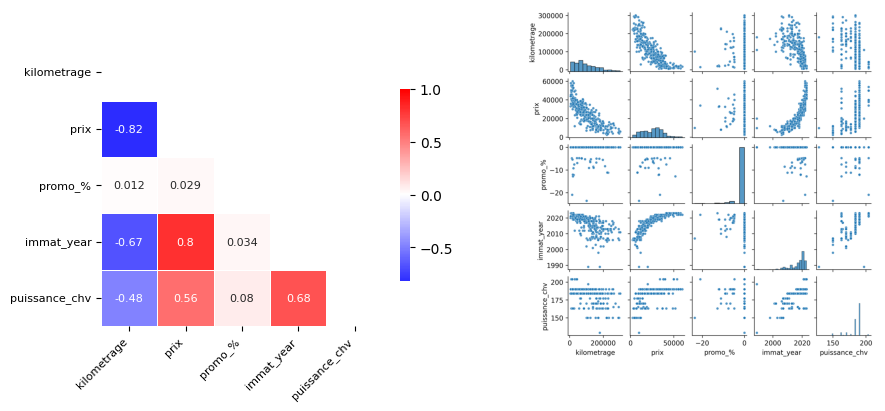

In [149]:
corr_matx_pairplot(df)

Les coorélation intra-features sont inférieures à 0.7 ; nous décidons de toutes les conserver.

## La variance

Il peut etre pertinent de supprimer des variables sur la base de leur variance (une feature a une variance nulle si sa valeur est identique pour toutes les instances et a donc peu d'intéret pour le modèle).

In [150]:
var_sel = VarianceThreshold(threshold=(0.02))
var_sel.fit(X_train_scl)
print("Selected features:", list(X_train_scl.columns[var_sel.get_support()]))
print("Features to be removed:", list(X_train_scl.columns[~var_sel.get_support()]))

Selected features: ['kilometrage', 'promo_%', 'immat_year', 'puissance_chv', 'transmission_Boîte manuelle', 'carburant_Electrique/Diesel', 'carburant_Electrique/Essence', 'carburant_Essence', 'seller_location_BE', 'seller_location_DE', 'seller_location_ES', 'seller_location_IT', 'seller_location_NL']
Features to be removed: ['transmission_Semi-automatique', 'carburant_Electrique']


In [151]:
X_train_scl_var = var_sel.transform(X_train_scl)
X_test_scl_var = var_sel.transform(X_test_scl)

## Force de la relation avec la target

La fonction SelectKbest permet de sélectionner une nombre spécifique de features à l'aide d'un test statistique univarié. Sont conservées les features qui ont une relation forte avec la target.

In [152]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [153]:
kbest = SelectKBest(score_func=f_regression, k=5)
kbest.fit(X_train_scl, y_train)

print("Selected features:", list(X_train_scl.columns[kbest.get_support()]))
print("Removed features:", list(X_train_scl.columns[~kbest.get_support()]))

Selected features: ['kilometrage', 'immat_year', 'puissance_chv', 'transmission_Boîte manuelle', 'carburant_Electrique/Essence']
Removed features: ['promo_%', 'transmission_Semi-automatique', 'carburant_Electrique', 'carburant_Electrique/Diesel', 'carburant_Essence', 'seller_location_BE', 'seller_location_DE', 'seller_location_ES', 'seller_location_IT', 'seller_location_NL']


In [154]:
X_train_scl_kbest = kbest.transform(X_train_scl)
X_test_scl_kbest = kbest.transform(X_test_scl)

# Entrainement et sélection du modèle

In [155]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, learning_curve, GridSearchCV, cross_validate
import time
import mlflow

In [156]:
#permet de disable certain warning lors de la gridsearch
import warnings
warnings.filterwarnings("ignore")

In [157]:
#permet de disable tous les messages d'info donné par MLflow lors du tracking
import logging, sys
logging.disable(sys.maxsize)

Nous sommes sur une problématique de ML supervisé (le prix des véhicules du dataset est connu) et de régression (prediction d'une valeur numérique continue).

Suivant les recommandations de Scikit Learn (*cf. algorithm selection diagram*), nous allons évaluer la performance des modèles suivants:
- Elastic net (régression linéaire régularisée)
- SVR

Une régression linéaire simple servira de benchmark

Pour évaluer la performance des modèles, nous allons nous appuyer sur deux metrics propres à la regression:
- RMSE : moyenne de la somme des écarts entre la valeur prédite par le modèle et la valeur réelle -> plus c'est bas, mieux c'est
- R-squared : indique la proportion de la variance de la target pouvant être expliquée par les features. Valeur comprise entre 0 et 1 -> plus c'est élevé, mieux c'est

## Fonctions

### Fonctions pour évaluer les performances du modèle

Nous allons évaluer les modèles en utilisant la cross-validation
- le trainig set est divisé @ random en 5 subsets (folds),
- le modèle est entrainé & évalué 5 fois : 4 folds sont utilisés pour l'entrainement et 1 pour la validation

Par ailleurs, nous avons réalisé une GridSearch pour finetuner les hyperparamètres des modèles : elle utilise la cross-validation pour évaluer toutes les combinaisons d'hyperparamètres.

*La Randomized search aurait été plus pertinente dans le cas où on explorerait plus de combinaisons (large hyperparameter search space).*

In [158]:
def search_best_model(model, X_train:np.array, y_train:np.array, param=None, mlfow_tracking=None):
   """Fonction qui entraine un modèle et retourne ses performances (cross-validation)
   Il est possible de soumettre des paramètres pour obtenir les résultats d'une gridsearch
   Il est possible d'enregistrer les résultats des modèles via MLflow

   Args:
       model : model sklearn non fitté (ex: LinearRegression())
       X_train (array): features préprocéssées
       y_train (array): target préprocéssée
       param (dict, optional): dictionaire de paramètres à tester pour la Gridsearch. Defaults to None.
       mlfow_tracking (str/int, optional): indique si on souhaite que les essais soient trackés via MLflow. Defaults to None.

   Returns:
       df_comp: un dataframe d'une ligne contenant les résultats obtenus avec le modèle
       best_param: un dictionnaire des meilleurs paramètres issus de la gridsearch

   """
    
   kfold = KFold(n_splits=5, shuffle=True, random_state=42)

   if mlfow_tracking is not None:
      mlflow.set_experiment(f"vehicule_pricer_{type(model).__name__}")
      mlflow.autolog()
   
   if param is not None:
    
       # find best parameters with Gridsearch
      search = GridSearchCV(model, param, scoring='neg_root_mean_squared_error', cv=kfold)
      result = search.fit(X_train, y_train)

       # print results of Gridsearch
      best_score = result.best_score_
      best_param = result.best_params_
      print(f"--{type(model).__name__}--\n")
      print(f"Le meilleur score obtenu avec la GridSearch est un RMSE de {-best_score:.2f} \navec les paramètres {best_param}.\n")
      fit_time = search.cv_results_["mean_fit_time"].mean()

       # compute best score of model based on best params through kfold cv
      model_f = model.set_params(**search.best_params_)
      score_1 = cross_val_score(model_f, X_train, y_train, cv=kfold, scoring='r2')
      print(f"Le R2 moyen de la cross validation est de {score_1.mean():.2f} avec un écart type de {score_1.std():.2f}.")
      score_2 = cross_val_score(model_f, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
      print(f"Le RMSE moyen de la cross validation est de {np.sqrt(-score_2.mean()):.2f} avec un écart type de {np.sqrt(score_2.std()):.2f}.")
      print(f"Fit time: {fit_time:.4f}s")

   else:
      print(f"--{type(model).__name__}--\n")
      score_1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
      print(f"Le R2 moyen de la cross validation est de {score_1.mean():.2f} avec un écart type de {score_1.std():.2f}.")
      score_2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
      print(f"Le RMSE moyen de la cross validation est de {np.sqrt(-score_2.mean()):.2f} avec un écart type de {np.sqrt(score_2.std()):.2f}.")
      start = time.time()
      model_f = model.fit(X_train, y_train)
      end = time.time()
      fit_time = end - start
      print(f"Fit time: {fit_time:.4f}s")
   
   if mlfow_tracking is not None:
      mlflow.autolog(disable=True)

   #creation d'un dataframe pour pouvoir comparer facilement
   data1={'Model':type(model).__name__,
           'R2_train_score':[score_1.mean()], 
           'RMSE_train_score':[np.sqrt(-score_2.mean())], 
           'Fit_time':[fit_time]}
   df_comp = pd.DataFrame(data1)
    
   if param is not None: 
      return df_comp, best_param
   else:
      return df_comp

In [159]:
def plot_learning_curve(estimator, X_train:np.array, y_train:np.array):
    """plot les performances du modèle en fonction de la taille du dataset pour le training set et le validation set

    Args:
        estimator (_type_): modele sklearn non fitté (ex: LinearRegression())
        X_train (array): features préprocéssées
        y_train (array): target préprocéssée
    """

    train_sizes, train_scores, valid_scores = learning_curve(estimator, X_train, y_train, cv= 10, train_sizes=np.linspace(0.1, 1, 20), scoring='neg_root_mean_squared_error', n_jobs=-1)

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)

    score_ = cross_val_score(LinearRegression(), X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    baseline_rmse = -score_.mean()

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label="training score")
    plt.fill_between(train_sizes, train_mean + train_std, train_mean-train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, valid_mean, color='green', marker='+', markersize=5, linestyle='--', label='validation score')
    plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean-valid_std, alpha=0.15, color='green')

    if type(estimator).__name__ != "LinearRegression":
        plt.axhline(y=baseline_rmse, color='black', label='baseline rmse')

    plt.title(f"Learning_curve du modele {type(estimator).__name__}")
    plt.xlabel("Training set Size")
    plt.ylabel("RMSE")
    plt.legend(loc="lower right")
    plt.show()

### Fonction une fois le modèle fitté

In [160]:
def fit_model(model, best_para:dict, X_train:np.array, y_train:np.array):
    
    modelf = model.set_params(**best_para)
    modelf.fit(X_train, y_train)

    return modelf

In [161]:
def plot_coef(model_fitted, X_train:np.array):
    """visualisation du poids de chaque feature sur la base de leur coefficient

    Args:
        model_fitted (_type_): model sklearn déjà fitté
        X_train (array): features
    """
    
    if type(model_fitted).__name__=='SVR':
        coef = model_fitted.coef_[0]
    else:
        coef = model_fitted.coef_

    print(f"\nMagnitude des coefficients:{np.sum(abs(coef)):,.3f}")
    fig = plt.figure(figsize=(15,4))
    plt.bar(np.arange(len(coef)), coef, color="#1E328F")
    plt.xticks(np.arange(len(coef)),X_train.columns, rotation=45, ha='right');
    return(np.sum(abs(coef)))

## Linear Regression

In [162]:
df_linreg = search_best_model(model=LinearRegression(), X_train=X_train_scl, y_train=y_train)

--LinearRegression--

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4827.56 avec un écart type de 2355.93.
Fit time: 0.0009s


In [163]:
df_linreg_var = search_best_model(model=LinearRegression(), X_train=X_train_scl_var, y_train=y_train)

--LinearRegression--

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4826.60 avec un écart type de 2351.02.
Fit time: 0.0006s


In [164]:
df_linreg_kbest = search_best_model(model=LinearRegression(), X_train=X_train_scl_kbest, y_train=y_train)

--LinearRegression--

Le R2 moyen de la cross validation est de 0.81 avec un écart type de 0.05.
Le RMSE moyen de la cross validation est de 5043.62 avec un écart type de 2546.23.
Fit time: 0.0005s


Les résultats sont légèrement supérieurs avec le retraitement de la variance dans les features.

In [165]:
linreg =LinearRegression()
linreg.fit(X_train_scl, y_train)
pred = linreg.predict(X_train_scl)
print(f"Training MSE : {mean_squared_error(y_train, pred, squared=False):.2f}")

Training MSE : 4507.77


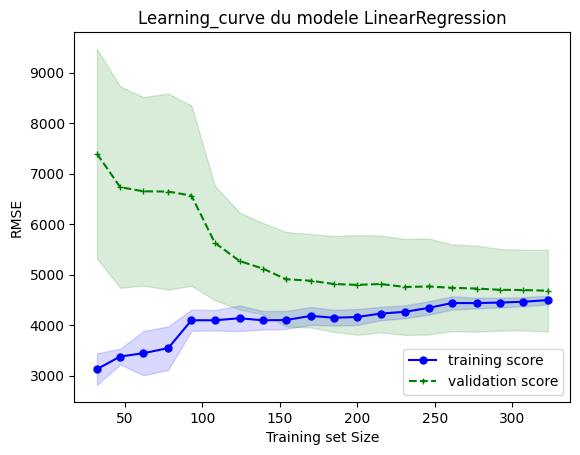

In [166]:
plot_learning_curve(LinearRegression(), X_train_scl, y_train)

Training curve

Quand il y a peu d'instances, le modèle parvient à fitter les datas aux mieux (avec quand meme une erreur de près de 3000€). Au fil de l'ajout de nouvelles instances au training set, le modèle a de plus en plus de mal à les fitter (les données sont *noisy* et peut etre pas linéaires). L'erreur sur le training set augmente donc (jusqu'à se stabiliser autour de 5000€).
L'erreur étant relativement importante (5000€ représente un large % du prix d'une voiture), on peut suspecter que nous sommes dans une situation **d'underfitting** : le modele ne fitte pas les données correctement (modèle probablement trop simple).

Validation curve

Quand le modèle est entrainé sur peu d'instances, il est incapable de généraliser correctement (erreur supérieure à 6000€). Puis, au fil de l'exposition à de nouvelles instances, le modèle apprend et l'erreur de validation diminue. L'erreur atteint rapidement un plateau, assez proche de la courbe du training set.

Les deux courbes étant proches (erreur de généralisation est faible) il ne semble pas y avoir de problème d'under/overfitting. Ajouter de la data ne semble pas non plus être la solution (les courbres semblent avoir atteint un plateau).


Magnitude des coefficients:43,113.071


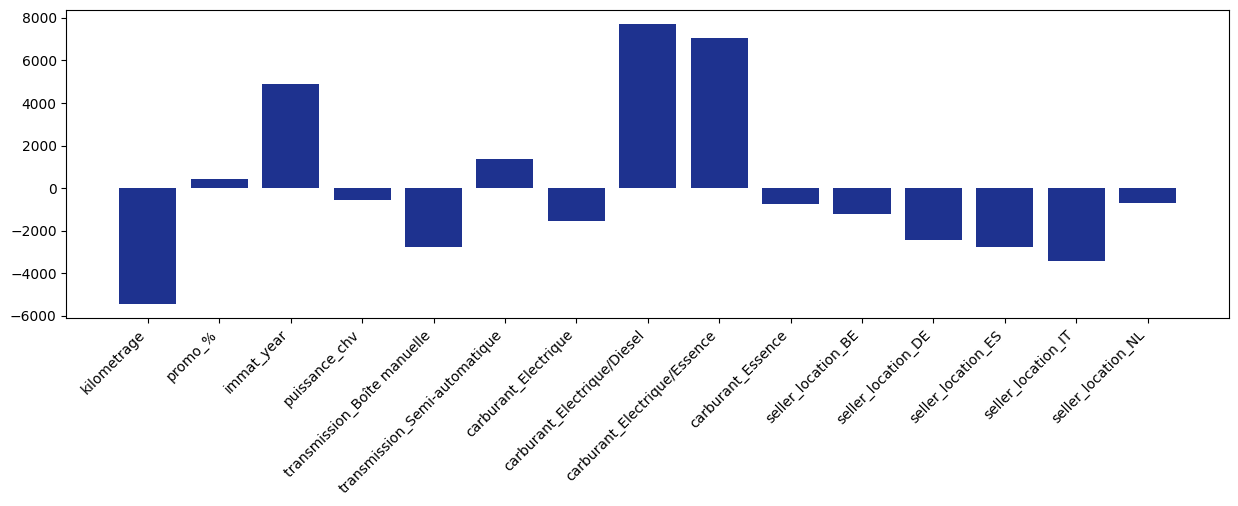

In [167]:
coef_linreg = plot_coef(linreg, X_train_scl)

Les coefficents mettent en évidence l'importance de chacune des features par rapport au prix du véhicule (le kilometrage, l'année d'immatriculation et le type de carburant semblent être les principaux paramètres influençant le prix du véhicule).

La régularisation a pour objectif de diminuer la magnitude de ces coefficients afin de limiter l'overfitting (cf. Lasso et Ridge implémentés dans l'Elastic net).

### Test statistique pour vérifier qu'il existe une relation entre les features et la target

Pour vérifier qu'il existe bien une relation entre les features et la target nous pouvons vérifier si leur coef = 0.
- Hypothèse nulle H0 : coef1 = coef2 = ... coefn = 0
- Hypothèse alternative Ha : au moins un des coef est non nul

Il faut calculer la F-Statistic ((TSS - RSS)/p) / (RSS/(n-p-1))
- si proche de 1 : pas de relation
- si > 1 : relation


TSS : total sum of square (somme des erreurs au carré)
RSS : residual sum of square
p : nb de feature
n : nb d'instances

In [168]:
import statsmodels.api as sm

In [169]:
X_stat = sm.add_constant(X_train_scl) #An intercept is not included by default and should be added by the user

In [170]:
y = np.asarray(y_train)
X = np.asarray(X_stat)

results = sm.OLS(y.astype('int64'), X.astype('float64')).fit() #necessaire de détailler le type sinon summary ne fonctionne pas
A = np.identity(len(results.params))
A = A[1:,:]
print(results.f_test(A))

<F test: F=126.42270124869782, p=1.2660950276792357e-129, df_denom=343, df_num=15>


In [171]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     126.4
Date:                Fri, 12 Jan 2024   Prob (F-statistic):          1.27e-129
Time:                        10:13:31   Log-Likelihood:                -3529.9
No. Observations:                 359   AIC:                             7092.
Df Residuals:                     343   BIC:                             7154.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.78e+04    620.043     44.843      0.000    2.66e+04     2.9e+04
x1         -5437.0390    364.692    -14.909      0.000   -6154.354   -4719.724
x2           428.7346    253.473      1.691      0.092     -69.822     927.291
x3          4910.4797    466.887     10.517      0.000    3992.158    5828.801
x4          -546.6794    367.031     -1.489      0.137   -1268.594     175.235
x5         -2773.6489    777.105     -3.569      0.000   -4302.140   -1245.158
x6          1365.6720   4718.745      0.289      0.772   -7915.647    1.06e+04
x7         -1563.7969   6561.731     -0.238      0.812   -1.45e+04    1.13e+04
x8          7712.9488   1314.964      5.866      0.000    5126.541    1.03e+04
x9          7058.6156   1432.511      4.927      0.000    4241.003    9876.228
x10         -754.9920    762.778     -0.990      0.323   -2255.304     745.320
x11        -1231.4933   1266.294     -0.973      0.331   -3722.173    1259.186
x12        -2417.5306    722.909     -3.344      0.001   -3839.424    -995.637
x13        -2782.1253   1275.645     -2.181      0.030   -5291.196    -273.055
x14        -3419.5765    889.171     -3.846      0.000   -5168.491   -1670.662
x15         -709.7385   1050.424     -0.676      0.500   -2775.822    1356.345
==============================================================================
Omnibus:                       74.460   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.950
Skew:                           1.013   Prob(JB):                     5.10e-40
Kurtosis:                       5.828   Cond. No.                         47.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La p value est très proche de 0 (Prob = 1.27e-129) ==> nous pouvons rejeter H0

Un test de signification peut nous aider à déterminer si nous devons opter pour un modèle complexe ou un modèle plus simple. Ici une régression linéaire fait sens.

## Elastic Net

Elastic Net permet de limiter l'overfitting d'une regression linéaire en implémentant de la régularisation. En l'occurence ce n'est pas ici un problème : la linear regression semble être un modèle trop simple (au vu des learning curves).

Nous allons quand meme faire tourner le modèle pour illustration.

In [172]:
param_grid = {
    "alpha":[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0], # alpha = 0 is equivalent to an ordinary least square
    'l1_ratio':[0.05, 0.2, 0.4, 0.6, 0.8, 1] # for l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty
    }

df_elnet, hp_elnet = search_best_model(model=ElasticNet(), param=param_grid, X_train=X_train_scl, y_train=y_train)

--ElasticNet--

Le meilleur score obtenu avec la GridSearch est un RMSE de 4791.39 
avec les paramètres {'alpha': 0.01, 'l1_ratio': 0.8}.

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4826.10 avec un écart type de 2366.77.
Fit time: 0.0015s


In [173]:
dummy_var1, dummy_var2 = search_best_model(model=ElasticNet(), param=param_grid, X_train=X_train_scl_var, y_train=y_train)

--ElasticNet--

Le meilleur score obtenu avec la GridSearch est un RMSE de 4791.05 
avec les paramètres {'alpha': 0.01, 'l1_ratio': 0.8}.

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4825.64 avec un écart type de 2364.57.
Fit time: 0.0010s


In [174]:
dummy_var1, dummy_var2 = search_best_model(model=ElasticNet(), param=param_grid, X_train=X_train_scl_kbest, y_train=y_train)

--ElasticNet--

Le meilleur score obtenu avec la GridSearch est un RMSE de 5004.64 
avec les paramètres {'alpha': 0.0, 'l1_ratio': 0.05}.

Le R2 moyen de la cross validation est de 0.81 avec un écart type de 0.05.
Le RMSE moyen de la cross validation est de 5043.62 avec un écart type de 2546.23.
Fit time: 0.0007s


In [175]:
elnet = fit_model(ElasticNet(), hp_elnet, X_train_scl, y_train)
pred = elnet.predict(X_train_scl)
print(f"Training MSE : {mean_squared_error(y_train, pred, squared=False):.2f}")

Training MSE : 4509.84


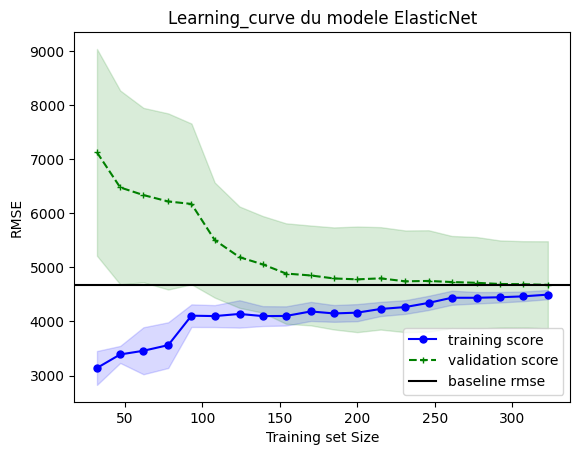

In [176]:
plot_learning_curve(ElasticNet().set_params(**hp_elnet), X_train_scl, y_train)

Les courbes de l'elastic net sont comparées au RMSE de la cross validation de la linear regression (ligne noire).

Les tendances des deux courbes ont des comportements similaires à la celles de la linear regression. On aboutit à la même conclusion : underfitting.


Magnitude des coefficients:39,280.250


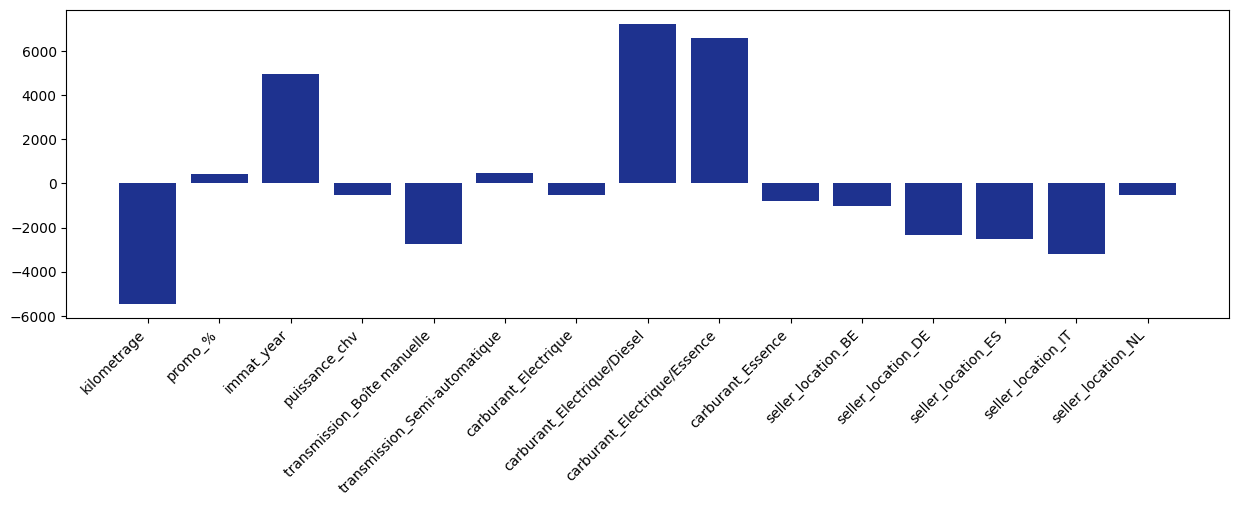

In [177]:
elnet = fit_model(ElasticNet(), hp_elnet, X_train_scl, y_train)
coef_elnet = plot_coef(elnet, X_train_scl)

La régularisation a induit une diminution des coefficients par rapport à la linear regression classique (ce qui était attendu).

## Polynomial regression

Dans la mesure ou la linear regression semble etre trop simple pour fitter nos data, nous allons complexifier le modèle en faisant une regression polynomiale.

In [178]:
def rmse_poly_reg(degree, X_train, y_train):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    polyreg = LinearRegression()
    polyreg.fit(X_train_poly, y_train)
    pred = polyreg.predict(X_train_poly)
    rmse = mean_squared_error(y_train, pred, squared=False)
    return rmse

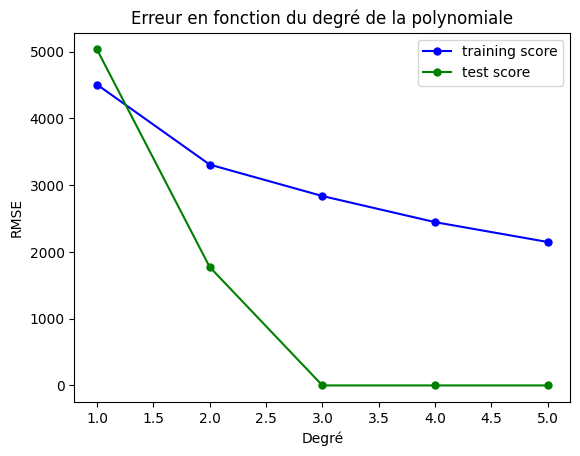

In [179]:
degree = []
rmse_train = []
rmse_test = []
for i in range(1,6):
    degree.append(i)
    rmse_train.append(rmse_poly_reg(i, X_train_scl, y_train))
    rmse_test.append(rmse_poly_reg(i, X_test_scl, y_test))
plt.plot(degree, rmse_train, color='blue', marker='o', markersize=5, label="training score")
plt.plot(degree, rmse_test, color='green', marker='o', markersize=5, label="test score")
plt.title(f"Erreur en fonction du degré de la polynomiale")
plt.xlabel("Degré")
plt.ylabel("RMSE")
plt.legend();

En effet, l'erreur diminue avec le degré de la polynomiale. Cependant, augmenter le degré diminu l'interprétabilité du modèle et n'est donc pas envisageable.

Par ailleurs, dans notre cas d'espèce, notre modèle semble fitter beaucoup mieux le test set que le train set !! A COMPRENDRE

## SVR

In [180]:
param_grid = {
    "kernel":['linear','rbf', 'poly'], 
    'C':[0.1, 1, 10, 100, 1000], # the strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
    'degree':[2,3,4] # degree of the polynomial kernel function.Ignored by all other kernels
    }

df_svr, hp_svr = search_best_model(model=SVR(), param=param_grid, X_train=X_train_scl, y_train=y_train)

--SVR--

Le meilleur score obtenu avec la GridSearch est un RMSE de 4788.42 
avec les paramètres {'C': 1000, 'degree': 2, 'kernel': 'linear'}.

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4825.90 avec un écart type de 2397.15.
Fit time: 0.0025s


In [181]:
dummy_var1, dummy_var2 = search_best_model(model=SVR(), param=param_grid, X_train=X_train_scl_var, y_train=y_train)

--SVR--

Le meilleur score obtenu avec la GridSearch est un RMSE de 4787.58 
avec les paramètres {'C': 1000, 'degree': 2, 'kernel': 'linear'}.

Le R2 moyen de la cross validation est de 0.82 avec un écart type de 0.04.
Le RMSE moyen de la cross validation est de 4825.12 avec un écart type de 2398.07.
Fit time: 0.0021s


In [182]:
dummy_var1, dummy_var2 = search_best_model(model=SVR(), param=param_grid, X_train=X_train_scl_kbest, y_train=y_train)

--SVR--

Le meilleur score obtenu avec la GridSearch est un RMSE de 5046.49 
avec les paramètres {'C': 1000, 'degree': 2, 'kernel': 'linear'}.

Le R2 moyen de la cross validation est de 0.80 avec un écart type de 0.05.
Le RMSE moyen de la cross validation est de 5082.72 avec un écart type de 2487.79.
Fit time: 0.0019s


In [183]:
svr = fit_model(SVR(), hp_svr, X_train_scl, y_train)
pred = svr.predict(X_train_scl)
print(f"Training MSE : {mean_squared_error(y_train, pred, squared=False):.2f}")

Training MSE : 4655.77


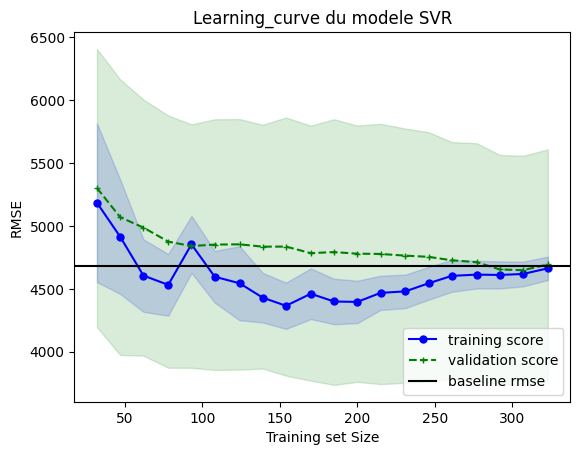

In [184]:
plot_learning_curve(SVR().set_params(**hp_svr), X_train_scl, y_train)


Magnitude des coefficients:31,560.188


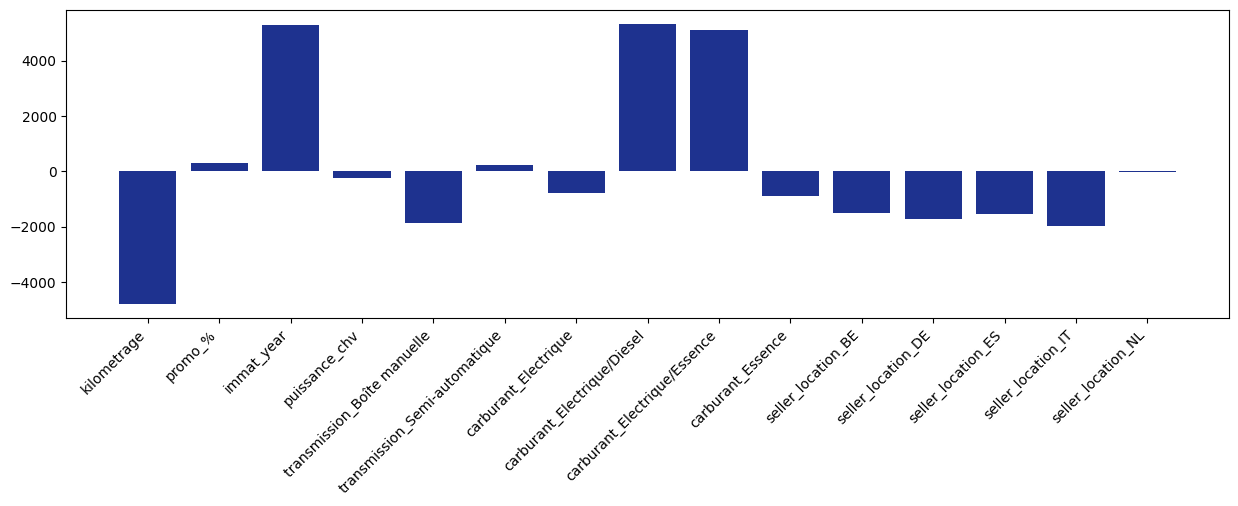

In [185]:
svr = fit_model(SVR(), hp_svr, X_train_scl, y_train)
# les coefs ne peuvent être calculés que pour un kernel linéaire
if svr.get_params()['kernel']=='linear':
    coef_svr = plot_coef(svr, X_train_scl)
else:
    coef_svr=np.nan

## Comparaison des performances des modèles

In [186]:
df_comp = pd.concat([df_linreg,df_elnet, df_svr])
df_comp['coef'] = [coef_linreg, coef_elnet, coef_svr]
df_comp = df_comp.sort_values("RMSE_train_score", ascending=True)
df_comp

,Model,R2_train_score,RMSE_train_score,Fit_time,coef
0,SVR,0.821881,4825.896888,0.002484,31560.188393
0,ElasticNet,0.821714,4826.098314,0.001501,39280.249619
0,LinearRegression,0.821485,4827.564712,0.000914,43113.071147


Les modèles aboutissent à des résultats comparables. Par simplicité, et parce que son temps de fit est largement inférieur, nous allons sélectionner la régression linéaire pour le pricer.

**A NOTER : les performances des 3 modèles ne sont pas bonnes**
- Un RMSE de 5000€ est trop élevé pour évaluer le prix d'un véhicule (pas suffisamment précis)

In [187]:
print(f"Le meilleur RMSE représente {df_comp['RMSE_train_score'].iloc[0]/y_train.mean()*100:.2f}% du prix moyen des véhicules du training set")

Le meilleur RMSE représente 18.67% du prix moyen des véhicules du training set


Le problème principal rencontré par les algorithmes est la **quantité insuffisante de données**. Un algorithme de ML a besoin de beaucoup de données pour fonctionner correctement. Même pour un problème assez simple comme celui ci, on a généralement besoin de milliers d'exemples.

Dans notre cas d'espece, les données récoltées concernent les informations (1) relatives à un **unique modèle** et (2) disponibles sur un **unique site** : le dataset est donc forcément limité.
- il ne semble pas opportunt d'augmenter la taille du dataset en ajoutant des données relatives à d'autres modèles/marques dans la mesure où la cote des véhicules est propre à chaque modèle
- la solution consisterait à scrapper des offres sur d'autres sites internets qui répertorient ce type d'offres. Deux problèmatiques : (1) de nombreux sites se protègent contre le scrapping (ex: LeBonCoin) et (2) risques de récupérer des offres doublons (cas d'un vendeur qui aurait posté son offre sur plusieurs plateformes) et donc de fausser les modèles.

*Rappel : ce projet avait pour objectif d'appliquer le scrapping de données à un cas concret*

Les autres défis typiques peuvent être écartés :
- données non représentatives (le risque est que le site autoscoot répertorie uniquement des offres 'haut de gamme' par exemple, ce qui limiterait la capacité à généraliser de notre modèle)
- données de mauvaises qualités
- features non pertinentes

# Performance du modèle sélectionné sur le test set

In [ ]:
# if based on specified model on MLflow

#best_model = 'runs:/a30f777c29714a2e99cd4fda2541fb0e/model'
#best_model = mlflow.pyfunc.load_model(best_model)

In [188]:
def evaluation(model_fitted, X_test:np.array, y_test:np.array):
    
    predictions = model_fitted.predict(X_test)
    final_rmse = mean_squared_error(y_test, predictions, squared=False)
    print(f"RMSE: {final_rmse:.2f}")
    print(f"Le RMSE représente {final_rmse/y_test.mean()*100:.2f}% du prix moyen des véhicules du test set")

In [189]:
best_model2 = linreg
evaluation(best_model2, X_test_scl, y_test)

RMSE: 7682.15
Le RMSE représente 28.92% du prix moyen des véhicules du test set


# Pricer

A partir du modèle sélectionné, implémentation d'un pricer.

L'utilisateur complète un certain nombre d'informations concernant son véhicule et obtient sa valeur de marché en retour.

Les informations à compléter sont :
- le kilométrage
- l'année de première immatriculation
- la puissance en chevaux
- le type de transmission
- le type de carburant
- le pays de vente
- le statut du vendeur

In [190]:
from statistics import mean

In [195]:
def pricer(kilometrage:int, year:int, transmission:str, carburant:str, puissance:int, location:str, type_vendeur:str, preprocessing, model_fitted):
    
    # on récupère dans le dictionnaire new_data uniquement les features qui vont servir pour la prédiction (par ex; on ne garde par les features qui ont été supprimé lors du preprocessing)
    new_data = {"kilometrage" : [kilometrage],
                "promo_%" : [0], # cette feature a été donnée au modèle pour qu'il puisse apprendre des patterns (notamment au niveau de la "cote" de certains modèles sur certains marchés), mais ce n'est pas une feature pertinente pour un vendeur qui cherche à connaitre la valeur de marché de son véhicule
                "immat_year" : [year],
                "puissance_chv" : [puissance],
                "transmission":[transmission],
                "carburant":[carburant],
                "seller_location":[location],
                "seller_type":[type_vendeur]}
    
    # on s'assure que l'utilisateur ne fait pas de fautre de frappe et/ou on restreint son panel de choix (il faut que les valeurs prises par les features soient coghérentes avec les données
    # sur lesquelles s'est entrainé le model)
    # on vérifie par rapport à X_train qui a des variables catégorielles (pas encore encodées)
    if transmission not in X_train.transmission.value_counts().index:
        print("Pour le type de transmission, veuillez choisir entre une des valeurs suivantes:")
        print(X_train.transmission.value_counts().index.to_list())
    
    if carburant not in X_train.carburant.value_counts().index:
        print("Pour le type de carburant, veuillez choisir entre une des valeurs suivantes:")
        print(X_train.carburant.value_counts().index.to_list())
    
    # on considère qu'il nous est impossible de répondre à la demande de l'utilisateur si le modèle n'a pas été entrainé sur le type de transmission/caruburant souhaité
    if (transmission not in X_train.transmission.value_counts().index) or (carburant not in X_train.carburant.value_counts().index):
        print("Malheureusement nous ne sommes pas en mesure de vous proposer un prix pour votre véhicule.")
        print("Si vous souhaitez une approximation, veuillez sélectionner une des propositions proposées")
        return
    
    # cas spécifique où le modèle n'a pas été entrainé pour le type de vendeur choisi : on propose la valo pour les autres vendeur du dataset
    if type_vendeur not in X_train.seller_type.value_counts().index:
        print("Nous pouvons uniquement vous proposer un résultat pour le type de vendeur suivant:")
        print(X_train.seller_type.value_counts().index.to_list()[0])
        new_data.update({"seller_type":[X_train.seller_type.value_counts().index[0]]})

    # cas spécifique où le modèle n'a pas été entrainé pour un pays spécifique : on propose une valo pour les différents pays du dataset + moyenne
    if location not in X_train.seller_location.value_counts().index:
        print("Malheureusement nous n'avons pas d'exemple de ce vehicule vendu dans votre pays.")
        print("Pour information, voici le prix que nous proposons pour d'autres pays d'origine\n")

        pred = []
        for code_country in X_train.seller_location.value_counts().index:
            new_data.update({"seller_location":[code_country]})
            X_new = pd.DataFrame(new_data)
            X_new_scl = preprocessing.transform(X_new)
            predictions = model_fitted.predict(X_new_scl)
            pred.append(predictions[0])
            print(f"Etant donné les caractéristiques de ce véhicule, nous préconisons un prix de {predictions[0]:,.2f}€ si vendu en {code_country}\n")
        print(f"Le prix moyen s'élève ainsi à {mean(pred):,.2f}€")

    else : 
        X_new = pd.DataFrame(new_data)
        X_new_scl = preprocessing.transform(X_new)
        predictions = model_fitted.predict(X_new_scl)
        display(X_new.style.hide())
        print(f"Etant donné les caractéristiques de ce véhicule, nous préconisons un prix de {predictions[0]:,.2f}€")

In [196]:
pricer(200000, 2016, "Boîte manuelle", "Diesel", 160, "ES", "Particulier", preprocessor, best_model2)

Nous pouvons uniquement vous proposer un résultat pour le type de vendeur suivant:
Professionnel


kilometrage,promo_%,immat_year,puissance_chv,transmission,carburant,seller_location,seller_type
200000,0,2016,160,Boîte manuelle,Diesel,ES,Professionnel


Etant donné les caractéristiques de ce véhicule, nous préconisons un prix de 13,840.16€
